# Alex Liddle
## University of Denver

# Chatbot
A chatbot is an intelligent piece of software that is capable of communicating and performing actions similar to a human. The goal of this project is to build a model that predicts answers using predefined patterns and responses. You are provided with a file named intents.json that contains these patterns. Words and classes files are provided as extra help. Feel free to make a more complex bot by extending the intents file. 

#### Possible chat with your bot
<code>
You: Hello, how are you? 
Bot: Hi there, how can I help?
You: what can you do?
Bot: I can guide you through Adverse drug reaction list, Blood pressure tracking, Hospitals and Pharmacies
You: thanks
Bot: My pleasure
You: see ya. got to go!
Bot: See you
</code>

In [291]:
import nltk
import string
import re
import sklearn
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy import stats
#nltk.download('stopwords') #<---uncomment if you haven't downloaded the stopwords library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [307]:
# Load pickle files
import urllib.request
import pickle

classes = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/classes.pkl"))
words   = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/words.pkl"))
words += ['are', 'can', 'do']#how', 'what', 'you', 'do', 'can']

In [308]:
# Load json file with answer patterns
import requests
import json

intents = json.loads(requests.get("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/intents.json").text)
#intents

Process patterns for nlp and clustering

In [325]:
df = pd.DataFrame(intents['intents'])
# explode pattern fields into new rows
df_intents = pd.DataFrame({
              col:np.repeat(df[col].values, df['patterns'].str.len())
              for col in df.columns.difference(['patterns'])
          }).assign(**{'patterns':np.concatenate(df['patterns'].values)})[df.columns.tolist()]
# re-add rows with no pattern
df_intents = df_intents.append(pd.DataFrame([{'context':d['context'], 
                                              'patterns':'', 
                                              'responses':d['responses'], 
                                              'tag':d['tag']} 
                                             for d in intents['intents'] if d['patterns']==[]])).reset_index()

In [341]:
tqdm.pandas()
stop = stopwords.words()

df_intents['patterns_vector'] = [[]]*len(df_intents.patterns.values)
df_intents['stemmed_pattern'] = ['']*len(df_intents.patterns.values)

#encoder = OrdinalEncoder()

for idx, val in df_intents.patterns.items():
    # Normalize words (i.e., convert to same case)
    lowered = val.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem words
    porter = nltk.PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    # make new column for cleaned text
    df_intents.set_value(idx, 'patterns_vector', stemmed)
    df_intents.set_value(idx, 'stemmed_pattern', stemmed)
    
#df_intents['ordinal_value'] = encoder.fit_transform(df_intents.stemmed_pattern.values.reshape(-1,1))
    
# Vectorize text
tfidf = TfidfVectorizer(
    min_df = 0,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english',
    use_idf = False,
)

tfidf.fit(df_intents.patterns_vector)
patterns_tfidf = tfidf.transform(df_intents.patterns_vector)

df_intents.patterns_vector = patterns_tfidf

# remove duplicate patterns
df_intents = df_intents.copy()[:48]
patterns_tfidf = patterns_tfidf.copy()[:48]

df_intents

/Users/alexisasexystud/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alexisasexystud/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alexisasexystud/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,index,context,patterns,responses,tag,patterns_vector,stemmed_pattern,patterns_cluster
0,0,[],Hi there,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",hi there,19
1,1,[],How are you,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",how are you,0
2,2,[],Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",is anyon there,18
3,3,[],Hey,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",hey,11
4,4,[],Hola,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",hola,22
5,5,[],Hello,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",hello,23
6,6,[],Good day,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",good day,15
7,7,[],Bye,"[See you!, Have a nice day, Bye! Come back aga...",goodbye,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",bye,27
8,8,[],See you later,"[See you!, Have a nice day, Bye! Come back aga...",goodbye,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",see you later,10
9,9,[],Goodbye,"[See you!, Have a nice day, Bye! Come back aga...",goodbye,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",goodby,21


In [342]:
def find_optimal_clusters(data, max_k):    
    k_list = range(2, max_k+1)
    
    sse = []
    for k in k_list:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            #sse.append(KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(data).inertia_)
            sse.append(MiniBatchKMeans(n_clusters=k, random_state=42).fit(data).inertia_)

    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

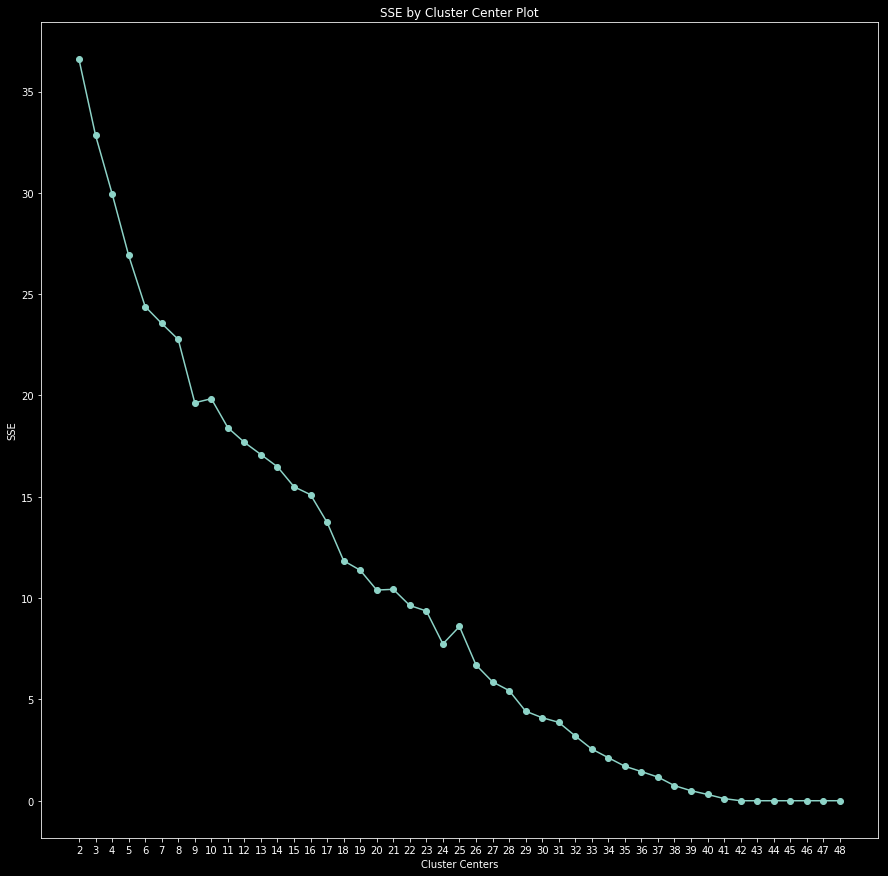

In [343]:
find_optimal_clusters(patterns_tfidf, patterns_tfidf.shape[0])

In [344]:
n_clusters = 42

#model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1).fit(patterns_tfidf)

model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(patterns_tfidf)

df_intents['patterns_cluster'] = model.predict(patterns_tfidf)
df_intents

,index,context,patterns,responses,tag,patterns_vector,stemmed_pattern,patterns_cluster
0,0,[],Hi there,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",hi there,19
1,1,[],How are you,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",how are you,0
2,2,[],Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",is anyon there,18
3,3,[],Hey,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",hey,11
4,4,[],Hola,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",hola,22
5,5,[],Hello,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",hello,23
6,6,[],Good day,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",good day,15
7,7,[],Bye,"[See you!, Have a nice day, Bye! Come back aga...",goodbye,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",bye,27
8,8,[],See you later,"[See you!, Have a nice day, Bye! Come back aga...",goodbye,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",see you later,10
9,9,[],Goodbye,"[See you!, Have a nice day, Bye! Come back aga...",goodbye,"(0, 19)\t1.0\n (2, 1)\t1.0\n (3, 18)\t1.0\...",goodby,21


In [345]:
user_prompt = ''

prompts = df_intents.patterns.values
responses = df_intents.responses.values

i = 0

missed = 0

print('Testing Chatbot')
print('-----------------------')

while True:
    user_prompt = prompts[i] #input("User: ")
    if user_prompt.lower()=='q':
        break
    lowered = user_prompt.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem and lemmatize words
    porter = nltk.PorterStemmer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    
    # vectorize
    test_vector = tfidf.transform([stemmed])

    predicted_cluster = model.predict(test_vector)[0]

    response = np.random.choice(list(df_intents[df_intents.patterns_cluster==predicted_cluster].responses)[0])

    r = responses[i]
    if response not in r:
        r = r[0]
        missed +=1
    else:
        r = response
    
    print('\nprompt:', user_prompt)
    print('predicted:', response)
    print('true:', r)
        
    i += 1
    if i==len(prompts):
        break

print('-----------------------')
print('\n\nModel Accuracy:',(len(prompts)-missed)/len(prompts))

Testing Chatbot
-----------------------

prompt: Hi there
predicted: Hi there, how can I help?
true: Hi there, how can I help?

prompt: How are you
predicted: Hi there, how can I help?
true: Hi there, how can I help?

prompt: Is anyone there?
predicted: Hello, thanks for asking
true: Hello, thanks for asking

prompt: Hey
predicted: Hello, thanks for asking
true: Hello, thanks for asking

prompt: Hola
predicted: Good to see you again
true: Good to see you again

prompt: Hello
predicted: Hello, thanks for asking
true: Hello, thanks for asking

prompt: Good day
predicted: Hi there, how can I help?
true: Hi there, how can I help?

prompt: Bye
predicted: Have a nice day
true: Have a nice day

prompt: See you later
predicted: Bye! Come back again soon.
true: Bye! Come back again soon.

prompt: Goodbye
predicted: Have a nice day
true: Have a nice day

prompt: Nice chatting to you, bye
predicted: Have a nice day
true: Have a nice day

prompt: Till next time
predicted: Have a nice day
true: Hav